In [1]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal, gdalconst

In [2]:
# Read in the raster NLCD landcover datasets as numpy arrays
directory = 'C:\\Users\\shenq\\Desktop\\sq\\geog788P\\QuanShen_MnM4SDS_project\\data\\'

nlcd04_file = os.path.join(directory, "NLCD_2004.tif")
nlcd04 = gdal.Open(nlcd04_file, gdalconst.GA_ReadOnly).ReadAsArray()

nlcd06_file = os.path.join(directory, "NLCD_2006.tif")
nlcd06 = gdal.Open(nlcd06_file, gdalconst.GA_ReadOnly).ReadAsArray()

nlcd08_file = os.path.join(directory, "NLCD_2008.tif")
nlcd08 = gdal.Open(nlcd08_file, gdalconst.GA_ReadOnly).ReadAsArray()

nlcd11_file = os.path.join(directory, "NLCD_2011.tif")
nlcd11 = gdal.Open(nlcd11_file, gdalconst.GA_ReadOnly).ReadAsArray()

nlcd13_file = os.path.join(directory, "NLCD_2013.tif")
nlcd13 = gdal.Open(nlcd13_file, gdalconst.GA_ReadOnly).ReadAsArray()

nlcd16_file = os.path.join(directory, "NLCD_2016.tif")
nlcd16 = gdal.Open(nlcd16_file, gdalconst.GA_ReadOnly).ReadAsArray()

# Make sure that the datasets are taken in appropriately, and that they have the same extent
print(nlcd04.shape, nlcd06.shape, nlcd16.shape)

(9441, 14646) (9441, 14646) (9441, 14646)


In [3]:
# Create a dataframe to store forest loss information
forest_loss = pd.DataFrame()
row = []
col = []
y06 = []
y08 = []
y11 = []
y13 = []
y16 = []
permanent = []

wide, high = nlcd04.shape

# find pixels of forest loss: forest in 2004, but experience forest loss later 
for i in range(wide):
    for j in range(high):
        if nlcd04[i][j] > 40 and nlcd04[i][j] < 50:
            if nlcd06[i][j]<40 or nlcd06[i][j]>50 or nlcd08[i][j]<40 or nlcd08[i][j]>50 \
            or nlcd11[i][j]<40 or nlcd11[i][j]>50 or nlcd13[i][j]<40 or nlcd13[i][j]>50:
                # Add landcover histroy to the pixel
                row.append(i)
                col.append(j)
                y06.append(int(nlcd06[i][j]/10)*10)
                y08.append(int(nlcd08[i][j]/10)*10)
                y11.append(int(nlcd11[i][j]/10)*10)
                y13.append(int(nlcd13[i][j]/10)*10)
                y16.append(int(nlcd16[i][j]/10)*10)

forest_loss['2006'] = y06
forest_loss['2008'] = y08
forest_loss['2011'] = y11
forest_loss['2013'] = y13
forest_loss['2016'] = y16
forest_loss['row'] = row
forest_loss['col'] = col
forest_loss.head()

,2006,2008,2011,2013,2016,row,col
0,80,80,80,80,80,1952,1221
1,80,80,80,80,80,1952,1222
2,80,80,80,80,80,1952,1223
3,80,80,80,80,80,1953,1221
4,80,80,80,80,80,1953,1222


In [5]:
# find non-permanent and permanent forest loss in 2004-2016
# forest lost and then recovered, not permanent loss
# forest lost but never recovered by 2016, permanent loss

for i in range(len(forest_loss)):
    change = 0
    for j in range (5):
        if forest_loss.iloc[i, j] != 40:
            change = 1
        if forest_loss.iloc[i, j] == 40 and change == 1: # not permanent loss
            permanent.append(0)
            break
        if j == 4 and forest_loss.iloc[i, j] != 40: # permanent loss
            permanent.append(1)

forest_loss['permanent'] = permanent
forest_loss.head()

,2006,2008,2011,2013,2016,row,col,permanent
0,80,80,80,80,80,1952,1221,1
1,80,80,80,80,80,1952,1222,1
2,80,80,80,80,80,1952,1223,1
3,80,80,80,80,80,1953,1221,1
4,80,80,80,80,80,1953,1222,1


In [7]:
# seperate the dataframe into two, based on the permanency of forest loss
non_permanent = forest_loss[forest_loss['permanent'] == 0]
permanent = forest_loss[forest_loss['permanent'] == 1]
non_permanent.head()

,2006,2008,2011,2013,2016,row,col,permanent
15,70,70,50,40,40,1959,1104,0
16,70,70,50,40,40,1960,1100,0
17,70,70,50,40,40,1960,1102,0
18,70,70,50,40,40,1960,1103,0
19,70,70,50,40,40,1961,1100,0


In [9]:
permanent.head()

,2006,2008,2011,2013,2016,row,col,permanent
0,80,80,80,80,80,1952,1221,1
1,80,80,80,80,80,1952,1222,1
2,80,80,80,80,80,1952,1223,1
3,80,80,80,80,80,1953,1221,1
4,80,80,80,80,80,1953,1222,1


In [10]:
# find the landcover types of forest gained from in the non-permanent forest loss dataframe
gain_from = []
for i in range(len(non_permanent)):
    if non_permanent.iloc[i, 0]!=40:
        gain_from.append(non_permanent.iloc[i, 0])
        continue
        
    elif non_permanent.iloc[i, 1]!=40:
        gain_from.append(non_permanent.iloc[i, 1])
        continue
        
    elif non_permanent.iloc[i, 2]!=40:
        gain_from.append(non_permanent.iloc[i, 2])
        continue
    
    elif non_permanent.iloc[i, 3]!=40:
        gain_from.append(non_permanent.iloc[i, 3])

non_permanent['gain_from'] = gain_from

C:\Users\shenq\Miniconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


70    57097
50    23625
10     5336
80     3465
90     1593
30      350
Name: gain_from, dtype: int64


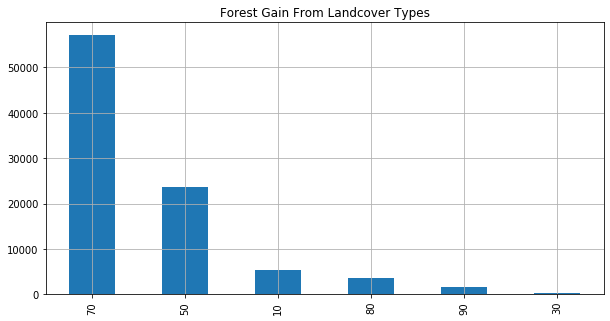

In [10]:
# add the 'gain from' landcover into the dataframe 
count = non_permanent['gain_from'].value_counts()
print(count)
# plot a histgram of the landcover 
count.plot(kind = 'bar', figsize=(10, 5), grid = True, title = "Forest Gain From Landcover Types")

In [15]:
# find the landcover types of forest lost to and the loss year in the permanent forest loss dataframe
loss_to = []
loss_year = []
for i in range(len(permanent)):
    if permanent.iloc[i, 0]!=40:
        loss_to.append(permanent.iloc[i, 0])
        loss_year.append('2006')
        continue
        
    elif permanent.iloc[i, 1]!=40:
        loss_to.append(permanent.iloc[i, 1])
        loss_year.append('2008')
        continue
        
    elif permanent.iloc[i, 2]!=40:
        loss_to.append(permanent.iloc[i, 2])
        loss_year.append('2011')
        continue
    
    elif permanent.iloc[i, 3]!=40:
        loss_to.append(permanent.iloc[i, 3])
        loss_year.append('2013')
        
permanent['loss_to'] = loss_to
permanent['loss_year'] = loss_year

C:\Users\shenq\Miniconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\shenq\Miniconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


70    116688
20     57076
80      8586
50      4008
10      1606
30      1386
90      1308
Name: loss_to, dtype: int64


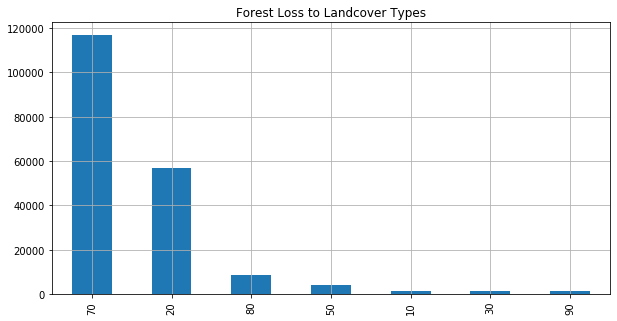

In [13]:
# add the "loss to" landcover into the dataframe 
count = permanent['loss_to'].value_counts()
print(count)
# plot the histgram
count.plot(kind = 'bar', figsize=(10, 5), grid = True, title = "Forest Loss to Landcover Types")

2006    75418
2011    60056
2013    32124
2008    23060
Name: loss_year, dtype: int64


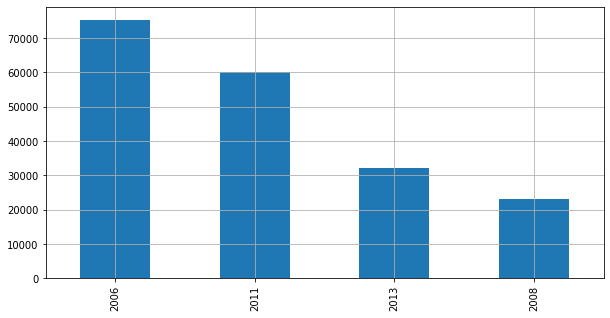

In [14]:
# add forest lost year in the dataframe
count = permanent['loss_year'].value_counts()
print(count)
# plot the histgram
count.plot(kind = 'bar', figsize=(10, 5), grid = True)

In [13]:
non_permanent.head(10)

,2006,2008,2011,2013,2016,row,col,permanent,gain_from
15,70,70,50,40,40,1959,1104,0,70
16,70,70,50,40,40,1960,1100,0,70
17,70,70,50,40,40,1960,1102,0,70
18,70,70,50,40,40,1960,1103,0,70
19,70,70,50,40,40,1961,1100,0,70
20,70,70,50,40,40,1961,1101,0,70
21,70,70,50,40,40,1961,1102,0,70
22,70,70,50,40,40,1961,1103,0,70
23,70,70,50,40,40,1961,1104,0,70
24,40,40,70,50,40,1961,1385,0,70


In [16]:
permanent.tail(10)

,2006,2008,2011,2013,2016,row,col,permanent,loss_to,loss_year
282087,40,40,40,80,80,8640,11575,1,80,2013
282088,40,40,40,80,80,8640,11576,1,80,2013
282090,40,40,40,80,80,8641,11575,1,80,2013
282091,40,40,40,80,80,8642,11574,1,80,2013
282116,70,70,70,70,50,8728,11423,1,70,2006
282117,70,70,70,70,50,8728,11424,1,70,2006
282118,70,70,70,70,50,8729,11424,1,70,2006
282119,70,70,70,70,50,8729,11425,1,70,2006
282120,70,70,70,70,50,8730,11424,1,70,2006
282121,70,70,70,70,50,8730,11425,1,70,2006
